In [1]:
import keras
import os

import numpy as np
import pandas as pd

from vit_keras import vit, utils
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn import preprocessing

from generator import DataGen

c:\Users\Lucas\anaconda3\envs\hackatoning\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
image_size = 384
classes = utils.get_imagenet_classes()
model = vit.vit_b16(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=True
)

inp = model.input
out = model.get_layer('ExtractToken').output

model = keras.Model(inp, out)

In [3]:
dgTrain = DataGen(input_shape=(384,384,3), shuffle=False, mode='train')
dgTest = DataGen(input_shape=(384,384,3), shuffle=False, mode='test', batch_size=36)

initialising train generator...
Generator fully initialised, 10416 samples available
initialising test generator...
Generator fully initialised, 3492 samples available


In [4]:
dgTrain.index

,fname,label
0,00133f89-017d-44f5-a549-e11cf5b5221a.tiff,advertisement
1,00a3e900-6616-46fe-a528-a5ac51952562.tiff,advertisement
2,0116aef3-5834-4a14-8dc0-e7eb3d79f5de.tiff,advertisement
3,024b107d-cd7f-4f81-a28c-50a9df08d586.tiff,advertisement
4,0296a9e1-5bec-456f-9e9c-fc8849203056.tiff,advertisement
...,...,...
10411,fa435c76-6b9c-4870-b7de-1e7936e1adbc.jpg,umowa_sprzedazy_samochodu
10412,fb9fc922-22ad-4fbf-acf0-64477b7b164f.jpg,umowa_sprzedazy_samochodu
10413,fc626b00-e310-44dc-a8dd-89e5269e8780.jpg,umowa_sprzedazy_samochodu
10414,fd1851af-5bf8-4934-9dd3-7502cfccabbd.jpg,umowa_sprzedazy_samochodu


In [7]:
path = os.path.join('data', 'results')

In [6]:
embedTrain = model.predict(dgTrain)

np.save(os.path.join(path, 'embeddings-train.npy'), embedTrain)
np.save(os.path.join(path, 'indices-train.npy'), dgTrain.indices)
dgTrain.index.to_csv(os.path.join(path, 'index-train.csv'))

97/97 [==============================] - 188s 2s/step


In [ ]:
embedTest = model.predict(dgTest)

np.save(os.path.join(path, 'embeddings-test.npy'), embedTest)
np.save(os.path.join(path,'indices-test.npy'), dgTest.indices)
dgTest.index.to_csv(os.path.join(path,'index-test.csv'))

In [8]:
embedTrain = np.load(os.path.join(path, 'embeddings-train.npy'))
indicesTrain = np.load(os.path.join(path, 'indices-train.npy'))
dfTrain = pd.read_csv(os.path.join(path, 'index-train.csv'))

embedTest = np.load(os.path.join(path, 'embeddings-test.npy'))
indicesTest = np.load(os.path.join(path, 'indices-test.npy'))
dfTest = pd.read_csv(os.path.join(path, 'index-test.csv'))

In [9]:
print(embedTrain.shape)
print(embedTest.shape)

(10400, 768)
(3491, 768)


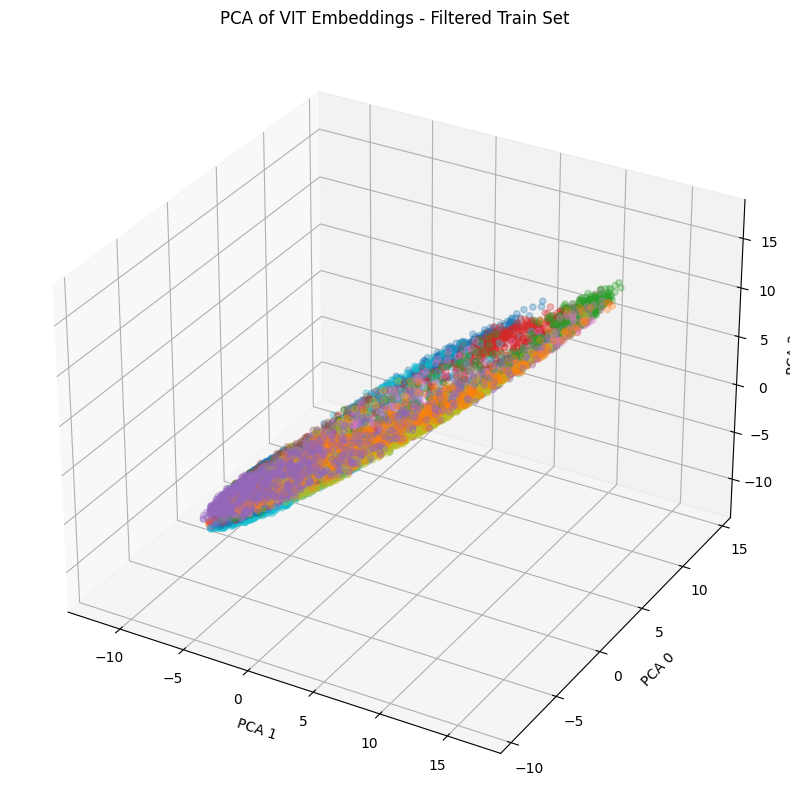

In [10]:
dfTrain = dfTrain.iloc[:-16]

pca = PCA(3)
pca_feats = pca.fit_transform(embedTrain, dfTrain['label'])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for label_id, label in enumerate(dfTrain['label'].unique()):
    ids = dfTrain[dfTrain['label']==label].index
    xs = pca_feats[ids,0]
    ys = pca_feats[ids,1]
    zs = pca_feats[ids,0]
    ax.scatter(xs, ys, zs, label=label, alpha=0.3)


ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 0')
ax.set_zlabel('PCA 2')
ax.set_title('PCA of VIT Embeddings - Filtered Train Set')

plt.show()

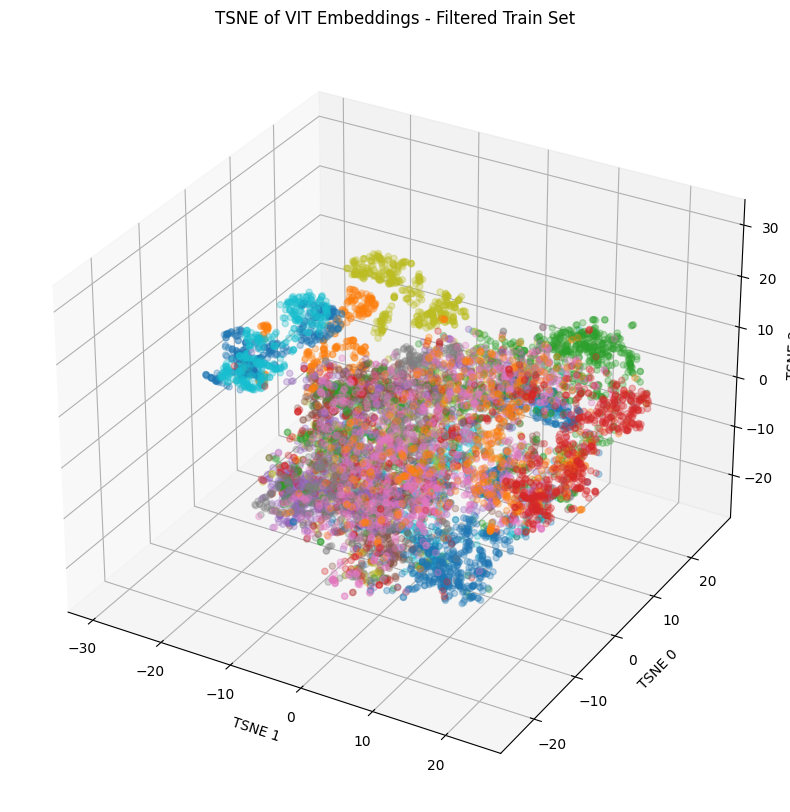

In [14]:
tsne_feats = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(embedTrain)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for label_id, label in enumerate(dfTrain['label'].unique()):
    ids = dfTrain[dfTrain['label']==label].index
    xs = tsne_feats[ids,0]
    ys = tsne_feats[ids,1]
    zs = tsne_feats[ids,2]
    ax.scatter(xs, ys, zs, label=label, alpha=0.3)


ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 0')
ax.set_zlabel('TSNE 2')
ax.set_title('TSNE of VIT Embeddings - Filtered Train Set')

plt.show()

In [15]:
clf = MLPClassifier((1024, 128), max_iter=500, verbose=False)
clf.fit(embedTrain, dfTrain['label'])

MLPClassifier(hidden_layer_sizes=(1024, 128), max_iter=500)

In [18]:
predictionsTrain = clf.predict(embedTrain)
np.save(os.path.join(path, 'predictions-train.npy'), predictionsTrain)

predictionsTest = clf.predict(embedTest)
np.save(os.path.join(path, 'predictions-test.npy'), predictionsTest)

In [19]:
scores = cross_val_score(clf, embedTrain, dfTrain['label'], cv=10)

print('Cross Validation Scores on Train Set')
print(scores)
print('')
print('Mean Cross Validation Score on Train Set')
print(scores.mean())

Cross Validation Scores on Train Set
[0.70961538 0.68557692 0.70961538 0.65       0.70096154 0.71153846
 0.69807692 0.65576923 0.68461538 0.67692308]

Mean Cross Validation Score on Train Set
0.6882692307692309


In [ ]:
#preds to csv

test = np.load(os.path.join(path, 'predictions-test.npy'))
test_idx = pd.read_csv(os.path.join(path, 'index-test.csv'))
#print(test.shape)
#print(test[0:5])
#print(test_idx["fname"])

new_df = pd.DataFrame(test)
#print(new_df)
result = pd.concat([test_idx["fname"], new_df], axis=1)
result.columns = ['filename', 'predict']
result.to_csv("output_test.csv",index=False)

le = preprocessing.LabelEncoder()
le.fit(result.predict)
test_idx_dp = le.transform(result.predict)
test_idx["predict"] = test_idx_dp
output_dict = dict(zip(test_idx.fname,test_idx.predict))
#print(output_dict)

data = {'filename': list(output_dict.keys()), 'predict': list(output_dict.values())}

#print(data["filename"])
#print(data["predict"])

final_df = pd.DataFrame(
    {'filename': data["filename"],
     'predict': data["predict"]
    })

final_df.to_csv("output_test_final.csv",index=False)

print("DOne")